In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
print("We're using TF", tf.__version__)
print("We are using Keras", keras.__version__)

We're using TF 2.2.0
We are using Keras 2.3.0-tf


In [3]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
#GPU count and name
!nvidia-smi -L

GPU 0: GeForce MX250 (UUID: GPU-78d227ff-6908-9dd8-0e18-3f65ce440a86)


In [5]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

Sat Sep 19 11:19:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce MX250       On   | 00000000:02:00.0 Off |                  N/A |
| N/A   38C    P0    N/A /  N/A |    503MiB /  2002MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# MNIST

In [13]:
# скачиваем данные
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

In [7]:
# что за данные
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[5 0 4 1 9 2 1 3 1 4]
[7 2 1 0 4 1 4 9 5 9]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


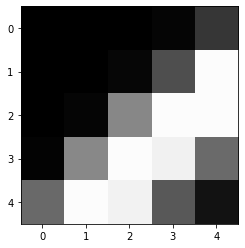

Пример картинки:


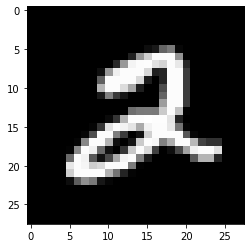

y_train [shape (60000,)] 10 примеров:
 [5 0 4 1 9 2 1 3 1 4]


In [7]:
# нарисуем картинку
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

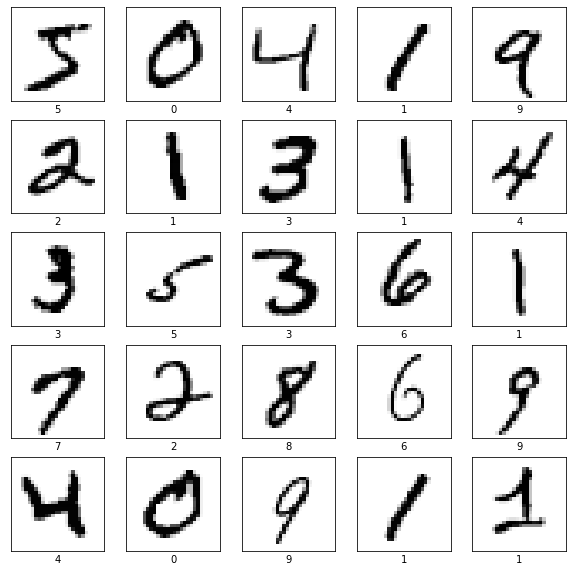

In [8]:
# Посмотрим побольше примеров
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="Greys")
    plt.xlabel(y_train[i])
plt.show()

# Data

In [9]:
# вытянем картинку в вектор размера 28*28=784 и будем использовать это как фичи!

x_train_flat = x_train.reshape(-1, 28*28).astype(float)
print(x_train.shape, x_train_flat.shape)

x_val_flat = x_val.reshape(-1, 28*28).astype(float)
print(x_val.shape, x_val_flat.shape)

(60000, 28, 28) (60000, 784)
(10000, 28, 28) (10000, 784)


In [14]:
# центрируем и нормируем, так сети будет проще учиться
x_train_float = x_train_flat.astype(np.float) / 255 - 0.5
x_val_float = x_val_flat.astype(np.float) / 255 - 0.5

# по сути, это действия аналогичны нормализации через StandardScaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x_train_flat = scaler.fit_transform(x_train_flat)
# x_val_flat = scaler.transform(x_val_flat)

# Но попробуйте пропустить нормирование и посмотрите что будет ;)
# x_train_float = x_train_flat.astype(np.float)
# x_val_float = x_val_flat.astype(np.float)

In [15]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]] [5 0 4 1 9]


# Собираем модель

Построим простой Multi layer Perceptron (MLP) классификатор в Keras (по аналогии со знакомым нам уже MLPClassifier из sklearn)

<img src="https://cdn-images-1.medium.com/max/1600/1*Gh5PS4R_A5drl5ebd_gNrg@2x.png" width="500">


Сначала надо будет посчитать логиты (logit, линейное преобразование) $z_k$ для каждого класса: $$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

А затем превратить логиты $z_k$ в вероятности $p_k$ при помощи функции softmax: $$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

Мы будем использовать cross-entropy для минимизации ошибки: $$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$

где $$ [x]=\begin{cases} 1, \quad \text{если $x$ истина} \\ 0, \quad \text{иначе} \end{cases} $$

Минимизация cross-entropy двигает $p_k$ в сторону 1 когда $y = k$, что как раз мы и хотим.


In [154]:
clear_session()

In [155]:
# Архитектура сети
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(x_train_float.shape[1],))) # первый скрытый слой
model.add(Dense(256, activation='relu',)) # второй скрытый слой
model.add(Dense(256, activation='relu',))
model.add(Dense(10, activation='softmax',)) # выходной слой

In [156]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 601,610
Trainable params: 601,610
Non-trainable params: 0
_________________________________________________________________


In [157]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [158]:
history = model.fit(
                    x_train_float, 
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
                    epochs=20,  # 10 проходов по датасету
                    validation_data=(x_val_float, y_val_oh)
                    )

Epoch 1/20
938/938 [==============================] - 3s 3ms/step - loss: 0.2843 - accuracy: 0.9118 - val_loss: 0.1692 - val_accuracy: 0.9463
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 0.1334 - accuracy: 0.9581 - val_loss: 0.1402 - val_accuracy: 0.9562
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 0.1035 - accuracy: 0.9672 - val_loss: 0.1029 - val_accuracy: 0.9684
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0847 - accuracy: 0.9727 - val_loss: 0.0950 - val_accuracy: 0.9705
Epoch 5/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0721 - accuracy: 0.9776 - val_loss: 0.1017 - val_accuracy: 0.9695
Epoch 6/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0605 - accuracy: 0.9805 - val_loss: 0.0970 - val_accuracy: 0.9711
Epoch 7/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0564 - accuracy: 0.9814 - val_loss: 0.0790 - val_accuracy: 0.9750
Epoch 

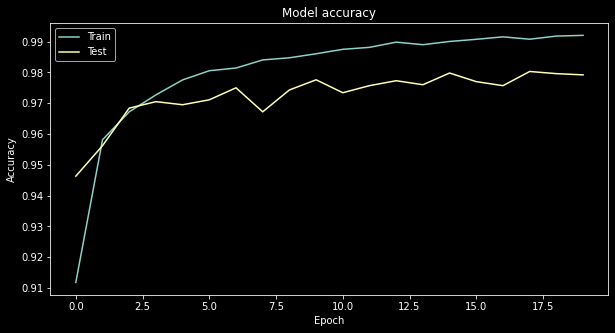

In [159]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

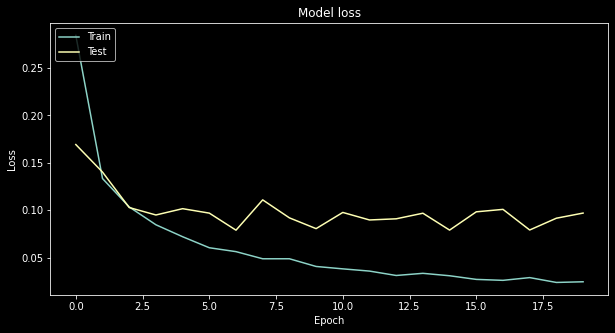

In [160]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [115]:
model.predict(x_val_float)

array([[2.22760976e-11, 9.17563412e-08, 9.70230829e-09, ...,
        9.99999046e-01, 6.47303999e-12, 1.02743414e-07],
       [1.47533814e-19, 8.32991065e-10, 1.00000000e+00, ...,
        8.16980760e-14, 1.50947276e-11, 1.04182333e-25],
       [1.43986723e-09, 9.99977231e-01, 1.68245651e-06, ...,
        9.31030536e-06, 1.43981174e-06, 1.33193510e-07],
       ...,
       [5.83982937e-23, 2.15334219e-15, 2.17316648e-20, ...,
        1.00230287e-15, 2.66803520e-15, 9.16963662e-13],
       [1.90245125e-14, 2.93356123e-16, 2.12641189e-16, ...,
        8.20183260e-17, 8.01455222e-11, 8.61320011e-18],
       [7.44989668e-14, 1.19681402e-18, 1.63390670e-16, ...,
        7.41348733e-20, 8.41278968e-15, 4.23551244e-15]], dtype=float32)

In [116]:
model.predict_classes(x_val_float)

array([7, 2, 1, ..., 4, 5, 6])

In [117]:
# аналогично
np.argmax(model.predict(x_val_float), axis = 1)

array([7, 2, 1, ..., 4, 5, 6])

In [161]:
predicts = model.predict_classes(x_val_float)
print('Test Accuracy: ', accuracy_score(y_val, predicts))

Test Accuracy:  0.9792
